In [93]:
from numpy.ma.core import max_filler

NAME = "Kevin Shefkiu"

---

# 0. Imports

---



In [94]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from random import random, randint
from queue import PriorityQueue
from copy import deepcopy
from time import time

# 1. Helper Classes and Starter Code

## 1.1 Perlin Noise

#### Function to create a 2d array of Perlin Noise. This is what creates the random terrains.

**Do not change any code here**

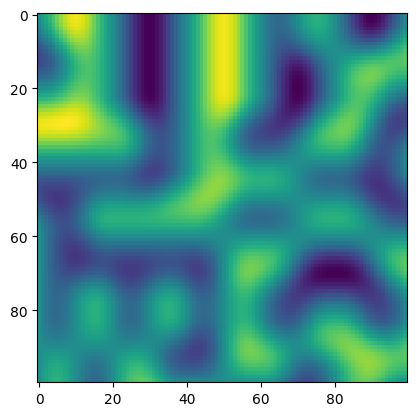

In [95]:
# Perlin noise code courtesy of tgroid on SO
def perlin(x,y,seed=0):
  def lerp(a,b,x):
    # linear interpolation
    return a + x * (b-a)

  def fade(t):
    # 6t^5 - 15t^4 + 10t^3
    return 6 * t**5 - 15 * t**4 + 10 * t**3

  def gradient(h,x,y):
    # gradient converts h to the right gradient vector and return the dot product with (x,y)
    vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
    g = vectors[h%4]
    return g[:,:,0] * x + g[:,:,1] * y

  # permutation table
  np.random.seed(seed)
  p = np.arange(256,dtype=int)
  np.random.shuffle(p)
  p = np.stack([p,p]).flatten()

  # coordinates of the top-left
  xi = x.astype(int)
  yi = y.astype(int)

  # internal coordinates
  xf = x - xi
  yf = y - yi

  # fade factors
  u = fade(xf)
  v = fade(yf)

  # noise components
  n00 = gradient(p[p[xi]+yi],xf,yf)
  n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
  n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
  n10 = gradient(p[p[xi+1]+yi],xf-1,yf)

  # combine noises
  x1 = lerp(n00,n10,u)
  x2 = lerp(n01,n11,u)
  return lerp(x1,x2,v)

lin = np.linspace(0,5,100,endpoint=False)
x,y = np.meshgrid(lin,lin)

perlin_noise = perlin(x,y, seed = randint(1,10000))
plt.imshow(perlin_noise ,origin='upper')
plt.show()

## 1.2 Point

#### Class that defines a single point in a search space and can be compared to other points

**Do not change any code here**

In [96]:
class Point():

	def __init__(self, posx, posy):
		self.x = posx
		self.y = posy
		self.f = math.inf

	def __lt__(self, other):
		return self.f < other.f

	def __gt__(self, other):
		return self.f > other.f

	def __eq__(self, other):
		return self.x == other.x and self.y == other.y

## 1.3 Map


#### Map class wraps an array representing the search terrain and provides functions to interact with the terrain

**Do not change any code here**

In [97]:
def scale(X):
	X = ((X+1)/2 * 255).astype(int)
	return X

class Map():

	def __init__(self, length, width, cost_function='exp',seed=None,
	             filename=None, start=None, goal=None):

		self.seed = seed
		if self.seed == None:
			# Randomly assign seed if one is not provided
			self.seed = randint(0,10000)

		self.length = length
		self.width = width

		self.map = None
		self.generate_terrain(filename)

		self.explored = []
		self.explored_lookup = {}
		self.num_explored_tracker = set() # Specifically to track the number of points whose heights have been polled. Used to calculate the number of points explored.

		# Set all points to be unexplored
		for i in range(self.width):
			for j in range(self.length):
				self.explored_lookup[str(i)+','+str(j)] = False

		# Define starting point
		if start == None:
			self.start = Point(int(self.width*0.5),int(self.length*0.5)) # default set start to middle of map
		else:
			self.start = Point(start[0], start[1])

	 	# Define goal point
		if goal == None:
			self.goal = Point(int((self.width-1)*0.9),int((self.length-1)*0.9)) # default set goal to bottom right corner of map
		else:
			self.goal = Point(goal[0], goal[1])

	  # Define cost function
		if cost_function == 'exp':
			self.cost_function = lambda h0, h1: math.pow(math.e,h1-h0)
		elif cost_function == 'sqdf':
			self.cost_function = lambda h0, h1: 1 + math.pow(h1 - h0, 2)

		self.cmap = mpl.colors.ListedColormap(['white', 'red'])

	def generate_terrain(self, filename=None):
		'''
		generate_terrain: modifies self.map to either be the specified file, or
		randomly generated from perlin noise.
		'''
		if filename is None:
			linx = np.linspace(0,5,self.width,endpoint=False)
			liny = np.linspace(0,5,self.length,endpoint=False)
			x,y = np.meshgrid(linx,liny)
			self.map = scale(perlin(x, y, seed=self.seed))

		else:
			self.map = np.load(filename)
			self.width = self.map.shape[0]
			self.length = self.map.shape[1]

	def interpolate(self, a0, a1, w):
		if (w < 0.0):
			return a0
		if (w > 1.0):
			return a1
		return (a1 - a0) * ((w * (w * 6.0 - 15.0) + 10.0) * w ** 3) + a0

	def calculate_path_cost(self, path):
		'''
		Calculate the cost of a path from start point to goal point
		'''
		prev = path[0]
		if self.start != prev:
			print('Path does not start at start. Path starts at point: ' , str(prev.x),
				',', str(prev.y))
			return math.inf
		cost = 0
		for item in path[1:]:
			if self.is_adjacent(prev, item):
				cost += self.get_cost(prev, item)
				prev = item
			else:
				print('Path does not connect at points: ', str(prev.x), ',', str(prev.y),
					' and ', str(item.x), ',', str(item.y))
				return math.inf
		if prev != self.goal:
			print('Path does not end at goal. Path ends at point: ' , str(prev.x),
				',', str(prev.y))
			return math.inf
		return cost

	def valid_tile(self, x, y):
		'''
		Do coords x and y form a valid point on the map
		'''
		return x >= 0 and y >= 0 and x < self.width and y < self.length

	def get_tile_height(self, x, y):
		''
		self.num_explored_tracker.add(f'{x},{y}')
		return self.map[x][y]

	def get_cost(self, p1, p2):
		'''
		Get cost of moving from point p1 to point p2
		'''
		h0 = self.get_tile_height(p1.x, p1.y)
		h1 = self.get_tile_height(p2.x, p2.y)
		return self.cost_function(h0, h1)

	def is_adjacent(self, p1, p2):
		'''
		Are points p1 and p2 adjacent
		'''
		return (abs(p1.x - p2.x) == 1 or abs(p1.y - p2.y)) == 1 and (abs(p1.x - p2.x) < 2 and abs(p1.y - p2.y) < 2)

	def get_neighbors(self, p1):
		'''
		Return all adjacent points to point p1 and track that we have now explored those adjacent points
		'''
		neighbors = []
		for i in [-1, 0, 1]:
			for j in [-1, 0, 1]:
				if i == 0 and j == 0:
					continue
				possible_point = Point(p1.x + i, p1.y + j)
				if self.valid_tile(possible_point.x, possible_point.y):
					neighbors.append(possible_point)
					if not self.explored_lookup[str(possible_point.x)+','+str(possible_point.y)]:
						self.explored_lookup[str(possible_point.x)+','+str(possible_point.y)] = True
						self.explored.append(possible_point)
						self.num_explored_tracker.add(f'{x},{y}')
		return neighbors

	def get_start_point(self):
		return self.start

	def get_goal_point(self):
		return self.goal

	def get_height(self):
		'''
		Get max height of map
		'''
		return np.amax(self.map)

	def get_num_explored(self):
		'''
		Get the number of points that were explored or whose heights were polled
		'''
		return len(self.num_explored_tracker)

	def create_image(self, path):
		'''
		Creates a 2D image of the path taken and points explored
		prints path cost and number of points explored
		'''

		img = self.map
		path_img = np.zeros_like(self.map)
		explored_img = np.zeros_like(self.map)
		for item in self.explored:
			explored_img[item.x, item.y] = 1
		path_img_x = [item.x for item in path]
		path_img_y = [item.y for item in path]
		print('Path cost:', self.calculate_path_cost(path))
		print('Points explored: ', self.get_num_explored())
		plt.imshow(img, cmap='gray')
		plt.imshow(explored_img, cmap=self.cmap, alpha=0.3)
		plt.plot(path_img_y, path_img_x, color='blue', linewidth=1)
		plt.show()

	def set_start_goal(self, start, goal):
		'''Set the start and goal point on the 2D map, each point is a pair of integers'''
		self.start = Point(np.clip(start[0], 0, self.length-1), np.clip(start[1], 0, self.width-1))
		self.goal = Point(np.clip(goal[0], 0, self.length-1), np.clip(goal[1], 0, self.width-1))

## 1.3 AI Module & Dijkstras

In [98]:

class AIModule:
	'''
	AIModule Interface
    create_path(map map_) -> list<points>: Adds points to a path
	'''

	def create_path(self, map_):
		pass

class StupidAI(AIModule):
	'''
	A sample AI that takes a very suboptimal path.
	This is a sample AI that moves as far horizontally as necessary to reach
	the target, then as far vertically as necessary to reach the target.
	It is intended primarily as a demonstration of the various pieces of the
	program.
	'''

	def create_path(self, map_):
		path = []
		# Get starting point
		path.append(map_.start)
		current_point = deepcopy(map_.start)

		# Keep moving horizontally until we match the target
		while(current_point.x != map_.goal.x):
			# If we are left of goal, move right
			if current_point.x < map_.goal.x:
				current_point.x += 1
			# If we are right of goal, move left
			else:
				current_point.x -= 1
			path.append(deepcopy(current_point))

		# Keep moving vertically until we match the target
		while(current_point.y != map_.goal.y):
			# If we are left of goal, move right
			if current_point.y < map_.goal.y:
				current_point.y += 1
			# If we are right of goal, move left
			else:
				current_point.y -= 1
			path.append(deepcopy(current_point))

		# We're done!
		return path

class Dijkstras(AIModule):

	def create_path(self, map_):
		# Priority Queue will return the Point with lowest f value
		fringe = PriorityQueue()

		'''
		Maintain three dictionaries to keep track of:

		cost ("x,y" -> cost per point) - lowest known cost of getting to this point from the start
		prev (point -> parent) - this keeps track of paths
		closed (point -> bool) - track which points have already been visited
		'''

		cost = {} # aka 'g'
		prev = {}
		closed = {}

		# Dictionary initialization
		for i in range(map_.width):
			for j in range(map_.length):

				cost[(i,j)] = math.inf # cost of all points starts at inf
				prev[(i,j)] = None # path is empty
				closed[(i,j)] = False # no points have been explored

		current_point = deepcopy(map_.start)
		current_point.f = 0
		cost[(current_point.x, current_point.y)] = 0 # cost to get to start point is 0

		# Add start point to the queue
		fringe.put(current_point)

		# Search loop: pop top point from priority queue until there are no points left
		while fringe.qsize() > 0:

			# Get new point from queue
			v = fringe.get()
			if closed[(v.x,v.y)]: # if point is already explored, then we skip
				continue
			closed[(v.x,v.y)] = True

			# Check if popped point is the goal, if so then we are done.
			if v == map_.get_goal_point():
				break

			# Get all adjacent points and evaluate them
			neighbors = map_.get_neighbors(v)
			for neighbor in neighbors:

				# Calulate path cost as: current cost to get to v + cost to get from v to the neighbor
				alternative_cost = cost[(v.x,v.y)] + map_.get_cost(v, neighbor) # aka 'g'

				# Is this new path is better than the previous best path to the neighbor, then update 
				if alternative_cost < cost[(neighbor.x,neighbor.y)]:

					# Update best known cost to the neighbor
					cost[(neighbor.x,neighbor.y)] = alternative_cost

					# Update the neighbors f value so that it can be reprioritized on priority queue
					neighbor.f = alternative_cost

					# Update the path the neighbor
					prev[(neighbor.x,neighbor.y)] = v

				# Add neighbor to the fringe to be explored
				fringe.put(neighbor)

		# Find and return path
		# v is still set to the goal point from the previous while loop
		path = []

		# Work backward from goal point to start point
		while v != map_.get_start_point():
			path.append(v)
			v = prev[(v.x,v.y)]

		path.append(map_.get_start_point())
		path.reverse()
		return path

# 2. A* and Admissable Heuristics (20 base pts + 5 bonus points)

In this section you will design your admissable heuristics and then implement A* using those heuristics

## 2.1 Designing Admissable Heuristics


### Exp Cost Function Heuristic

---
h(n) = max ( abs(goal_node.x - current_node.x), abs(goal_node.y - current_node.y))

At first it calculates the Chebyshev distance. Then it calculates the height difference between the 2 nodes.
If the current node is lower than the goal it increases the distance with this mathematics equation:
h(n) += e - 1

The - 1 removes the real movement cost and the e adds penalty for steepness

If the current node is higher than the goal:

h(n) += 1 / math.exp(abs( current_node_height - goal_height)) - abs( current_node_height - goal_height)

The - abs( current_node_height - goal_height) is to give a weigheted penalty. The higher height difference the higher penalty.

In this way it penalizes downward movement.

---
My heuristic is admissible because it never overestimates the true cost of the path. In fact, it limits movements by penalizing too expensive options never overestimating.
It is also consistent and follows the triangle inequality. The cost between 2 nodes is always less or equal than the g(n) + h(n).
My intuition came from real life experiences. In fact, the shortest path isn't always the optimal one. Usually if a path is too steep it might be better to choose a less steep, but longer route.

---
### Sqdf Cost Function Heuristic

---
h(n) = max (abs(goal_node.x - current_node.x), abs(goal_node.y - current_node.y))

---
This heuristic is the Chebyshev distance. It admissible because it never overestimates the true cost of the path. In fact, it cannot overestimate as it is simply evaluating the number of steps that allow the largest movement.
The Chebyshev distance is consistent because it doesn't add any adjustments.

---

## 2.2 AStarExp & AStarSqdf
Here is where you will write your A* algorithms for the exp and sqdf cost functions.
Start by copying Dijkstras.create_path

In [99]:
class AStarSqdf(AIModule):

	def heuristicSqdf(self, neighbor, goal):
		return max(abs(neighbor.x - goal.x), abs(neighbor.y - goal.y))

	def create_path(self, map_):
		# Priority Queue will return the Point with lowest f value
		fringe = PriorityQueue()

		'''
		Maintain three dictionaries to keep track of:

		cost ("x,y" -> cost per point) - lowest known cost of getting to this point from the start
		prev (point -> parent) - this keeps track of paths
		closed (point -> bool) - track which points have already been visited
		'''

		cost = {} # aka 'g'
		prev = {}
		closed = {}

		# Dictionary initialization
		for i in range(map_.width):
			for j in range(map_.length):

				cost[(i,j)] = math.inf # cost of all points starts at inf
				prev[(i,j)] = None # path is empty
				closed[(i,j)] = False # no points have been explored

		current_point = deepcopy(map_.start)
		current_point.f = 0
		cost[(current_point.x, current_point.y)] = 0 # cost to get to start point is 0

		# Add start point to the queue
		fringe.put(current_point)

		# Search loop: pop top point from priority queue until there are no points left
		while fringe.qsize() > 0:

			# Get new point from queue
			v = fringe.get()
			if closed[(v.x,v.y)]: # if point is already explored, then we skip
				continue
			closed[(v.x,v.y)] = True

			# Check if popped point is the goal, if so then we are done.
			if v == map_.get_goal_point():
				break

			# Get all adjacent points and evaluate them
			neighbors = map_.get_neighbors(v)
			for neighbor in neighbors:

				# Calulate path cost as: current cost to get to v + cost to get from v to the neighbor
				alternative_cost = cost[(v.x,v.y)] + map_.get_cost(v, neighbor) # aka 'g'

				# Is this new path is better than the previous best path to the neighbor, then update
				if alternative_cost < cost[(neighbor.x,neighbor.y)]:

					# Update best known cost to the neighbor
					cost[(neighbor.x,neighbor.y)] = alternative_cost

					# Update the neighbors f value so that it can be reprioritized on priority queue
					neighbor.f = alternative_cost + self.heuristicSqdf(neighbor, map_.get_goal_point())

					# Update the path the neighbor
					prev[(neighbor.x,neighbor.y)] = v

				# Add neighbor to the fringe to be explored
				fringe.put(neighbor)

		# Find and return path
		# v is still set to the goal point from the previous while loop
		path = []

		# Work backward from goal point to start point
		while v != map_.get_start_point():
			path.append(v)
			v = prev[(v.x,v.y)]

		path.append(map_.get_start_point())
		path.reverse()
		return path

class AStarExp(AIModule):

	def heuristicExp(self, neighbor, goal, map_):

		neighborHeight = map_.get_tile_height(neighbor.x, neighbor.y)
		goalHeight = map_.get_tile_height(goal.x, goal.y)

		cost = max(abs(neighbor.x - goal.x), abs(neighbor.y - goal.y))

		if neighborHeight > goalHeight:
			cost += 1 / math.exp(abs(neighborHeight - goalHeight)) - abs(neighborHeight - goalHeight)
		elif neighborHeight < goalHeight:
			for _ in range(int(abs(goalHeight - neighborHeight))):
				cost += math.exp(1) - 1

		return cost

	def create_path(self, map_):
		# Priority Queue will return the Point with lowest f value
		fringe = PriorityQueue()

		'''
		Maintain three dictionaries to keep track of:

		cost ("x,y" -> cost per point) - lowest known cost of getting to this point from the start
		prev (point -> parent) - this keeps track of paths
		closed (point -> bool) - track which points have already been visited
		'''

		cost = {} # aka 'g'
		prev = {}
		closed = {}


		# Dictionary initialization
		for i in range(map_.width):
			for j in range(map_.length):

				cost[(i,j)] = math.inf # cost of all points starts at inf
				prev[(i,j)] = None # path is empty
				closed[(i,j)] = False # no points have been explored

		current_point = deepcopy(map_.start)
		current_point.f = 0
		cost[(current_point.x, current_point.y)] = 0 # cost to get to start point is 0

		# Add start point to the queue
		fringe.put(current_point)

		# Search loop: pop top point from priority queue until there are no points left
		while fringe.qsize() > 0:

			# Get new point from queue
			v = fringe.get()
			if closed[(v.x,v.y)]: # if point is already explored, then we skip
				continue
			closed[(v.x,v.y)] = True

			# Check if popped point is the goal, if so then we are done.
			if v == map_.get_goal_point():
				break

			# Get all adjacent points and evaluate them
			neighbors = map_.get_neighbors(v)
			for neighbor in neighbors:

				# Calulate path cost as: current cost to get to v + cost to get from v to the neighbor
				alternative_cost = cost[(v.x,v.y)] + map_.get_cost(v, neighbor) # aka 'g'

				# Is this new path is better than the previous best path to the neighbor, then update
				if alternative_cost < cost[(neighbor.x,neighbor.y)]:

					# Update best known cost to the neighbor
					cost[(neighbor.x,neighbor.y)] = alternative_cost

					# Update the neighbors f value so that it can be reprioritized on priority queue
					neighbor.f = alternative_cost + self.heuristicExp(neighbor, map_.get_goal_point(), map_)

					# Update the path the neighbor
					prev[(neighbor.x,neighbor.y)] = v

				# Add neighbor to the fringe to be explored
				fringe.put(neighbor)

		# Find and return path
		# v is still set to the goal point from the previous while loop
		path = []

		# Work backward from goal point to start point
		while v != map_.get_start_point():
			path.append(v)
			v = prev[(v.x,v.y)]

		path.append(map_.get_start_point())
		path.reverse()
		return path

### Preliminary validation that your algorithms work (not graded)

Here you can run your agents and make sure that they find the optimal path and (hopefully) explore fewer points than Dijkstra's Algorithm.

We know that Dijkstra's Algorithm finds the optimal path (or one of multiple optimal paths), so if the cost of the path that your algorithm finds is not equal to the cost Dijkstra's found, it is wrong

### Parameters for running a test

w(int): Width of map

l(int): Length of map

start(array-like): Start position

goal(array-like): Goal position

seed(int): Seed for random generation

AI(AIModule): AI agent to use. Use any of the following: AStarExp, AStarSqdf, AStarExpImproved, Djikstras

cost_function(str): Cost function to use: 'exp' or 'sqdf'

filename(string): Filepath for .npy file to be used for map


In [100]:
width, length = 100, 100 
start, goal = None, None 
seed = 0
# seed = randint(0, 10000)
# cost_function = 'sqdf' # change from to 'exp' when you want to test AStarExp
cost_function = 'exp'

Time (s):  0.5808031558990479
Path cost: 56.633140406954254
Points explored:  2312


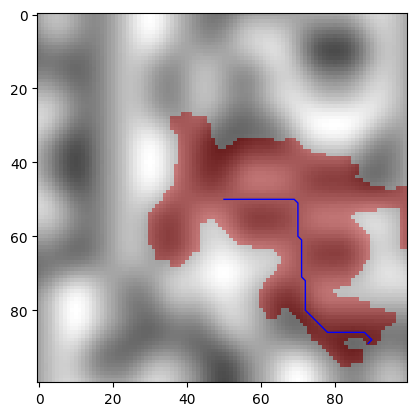

In [101]:
# Your A*
# AI = AStarSqdf() # change to AStarExp() if you want to test AStarExp()
AI = AStarExp()

m = Map(width,length, seed=seed, cost_function = cost_function, filename= None,
        start=start, goal=goal)
t1 = time()
path = AI.create_path(m)
t2 = time()
print('Time (s): ', t2-t1)
m.create_image(path)

Time (s):  0.8647348880767822
Path cost: 56.633140406954254
Points explored:  3383


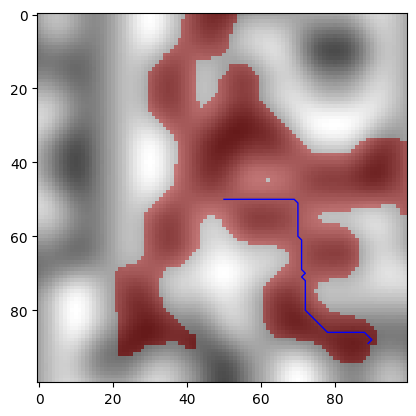

In [102]:
# Dijkstras
AI = Dijkstras()

m = Map(width,length, seed=seed, cost_function = cost_function, filename=None,
        start=start, goal=goal)
t1 = time()
path = AI.create_path(m)
t2 = time()
print('Time (s): ', t2-t1)
m.create_image(path)

## 2.3 Testing

Run the tests below to ensure that your heuristics are admissable and that your implementation of A* is correct.

**Do not write or modify any code here, just run the cells. If you would like to create your own test cases, please create them in separate cells**

#### Grading:

There are additional test cases (not visible to you) that I will run to ensure your heuristics are admissable. Passing the 20 test cases below is a good sign, but does not mean that your heuristics are admissable or that you will recieve full points.

You can still receive partial credit if you fail some of the hidden test cases, but if your code does not even pass the 20 visisble test cases below, you will receive no credit for this section

In [103]:
def runTest(seed, optimal_cost, AI, cost_function, width, length, start = None, goal = None):
  m = Map(width,length, seed=seed, cost_function = cost_function, filename=None,
        start=start, goal=goal)

  path = AI.create_path(m)
  path_cost = m.calculate_path_cost(path)
  num_explored = m.get_num_explored()
  assert round(path_cost, 5) == round(optimal_cost, 5), f'Incorrect path returned on seed {seed} | Your path cost: {path_cost} | Optimal Cost: {optimal_cost}'
  print(f'Test passed on seed {seed}')
  return num_explored


### 2.3.1 AStarExp Tests

In [104]:
AI = AStarExp()

cost_function = 'exp'
width = 300
length = 300

test_cases_exp = [
    {
        'seed' : 0,
        'optimal_cost' : 157.2575330558591,
        'start' : None,
        'goal' : None,
        'num_explored': 52746
    },
    {
        'seed' : 1,
        'optimal_cost' : 160.79626462417713,
        'start' : None,
        'goal' : None,
        'num_explored': 42338
    },
    {
        'seed' : 2,
        'optimal_cost' : 144.77755269410054,
        'start' : None,
        'goal' : None,
        'num_explored': 27545
    },
    {
        'seed' : 3,
        'optimal_cost' : 463.7989438075798,
        'start' : (int(width*0.9),int(length*0.4)),
        'goal' : (int(width*0.1),int(length*0.8)),
        'num_explored': 87591
    },
    {
        'seed' : 4,
        'optimal_cost' : 36.34464507852195,
        'start' : (int(width*0.5),int(length*0.6)),
        'goal' : (int(width*0.5),int(length*0.7)),
        'num_explored': 3134
    },
    {
        'seed' : 5,
        'optimal_cost' : 544.5376758993137,
        'start' : (int(width* 0),int(length*0)),
        'goal' : (int(width* 1) - 1,int(length*1) - 1),
        'num_explored': 89588
    },
    {
        'seed' : 6,
        'optimal_cost' : 472.75843219296104,
        'start' : (int(width*0.83),int(length*0.84)),
        'goal' : (int(width*0.1),int(length*0.1)),
        'num_explored': 88923
    },
    {
        'seed' : 7,
        'optimal_cost' : 525.403999076118,
        'start' : (int(width*1.0) - 1,int(length*1.0) - 1),
        'goal' : (int(width*0.0),int(length*0.0)),
        'num_explored': 89129
    },
    {
        'seed' : 8,
        'optimal_cost' : 348.7655328272431,
        'start' : (int(width*0.43),int(length*0.78)),
        'goal' : (int(width*0.02),int(length*0.2)),
        'num_explored': 82162
    },
    {
        'seed' : 9,
        'optimal_cost' : 301.7485237404068,
        'start' : None,
        'goal' : None,
        'num_explored': 89608
    },
]

explored_diff_sum = 0 

for t in test_cases_exp:
    a_num_explored = runTest(t['seed'], t['optimal_cost'], AI, cost_function, width, length, t['start'], t['goal'])
    d_num_explored = t['num_explored']

    explored_diff = d_num_explored - a_num_explored 

    explored_diff_sum += explored_diff / d_num_explored

explored_diff_mean =  (explored_diff_sum / len(test_cases_exp)) * 100

print(f'mean_explored_points_decrease: {round(explored_diff_mean, 2)}%   (should be greater than 50%)')


Test passed on seed 0
Test passed on seed 1
Test passed on seed 2
Test passed on seed 3
Test passed on seed 4
Test passed on seed 5
Test passed on seed 6
Test passed on seed 7
Test passed on seed 8
Test passed on seed 9
mean_explored_points_decrease: 66.82%   (should be greater than 50%)


### 2.3.2 AStarSqdf Tests

In [105]:
AI = AStarSqdf()

cost_function = 'sqdf'
width = 300
length = 300

test_cases_sqdf = [
    {
        'seed' : 0,
        'optimal_cost' : 227.0,
        'start' : None,
        'goal' : None,
        'num_explored': 67888
    },
    {
        'seed' : 1,
        'optimal_cost' : 255.0,
        'start' : None,
        'goal' : None,
        'num_explored': 61500
    },
    {
        'seed' : 2,
        'optimal_cost' : 212.0,
        'start' : None,
        'goal' : None,
        'num_explored': 45845
    },
    {
        'seed' : 3,
        'optimal_cost' : 464.0,
        'start' : (int(width*0.9),int(length*0.4)),
        'goal' : (int(width*0.1),int(length*0.8)),
        'num_explored': 85950
    },
    {
        'seed' : 4,
        'optimal_cost' : 40.0,
        'start' : (int(width*0.5),int(length*0.6)),
        'goal' : (int(width*0.5),int(length*0.7)),
        'num_explored': 2965
    },
    {
        'seed' : 5,
        'optimal_cost' : 610.0,
        'start' : (int(width* 0),int(length*0)),
        'goal' : (int(width* 1) - 1,int(length*1) - 1),
        'num_explored': 89035
    },
    {
        'seed' : 6,
        'optimal_cost' : 464.0,
        'start' : (int(width*0.83),int(length*0.84)),
        'goal' : (int(width*0.1),int(length*0.1)),
        'num_explored': 86320
    },
    {
        'seed' : 7,
        'optimal_cost' : 609.0,
        'start' : (int(width*1.0) - 1,int(length*1.0) - 1),
        'goal' : (int(width*0.0),int(length*0.0)),
        'num_explored': 89553
    },
    {
        'seed' : 8,
        'optimal_cost' : 398.0,
        'start' : (int(width*0.43),int(length*0.78)),
        'goal' : (int(width*0.02),int(length*0.2)),
        'num_explored': 83627
    },
    {
        'seed' : 9,
        'optimal_cost' : 301.0,
        'start' : None,
        'goal' : None,
        'num_explored': 86908
    },
]

explored_diff_sum = 0 

for t in test_cases_sqdf:
    a_num_explored = runTest(t['seed'], t['optimal_cost'], AI, cost_function, width, length, t['start'], t['goal'])
    d_num_explored = t['num_explored']

    explored_diff = d_num_explored - a_num_explored 

    explored_diff_sum += explored_diff / d_num_explored

explored_diff_mean =  (explored_diff_sum / len(test_cases_sqdf)) * 100

print(f'mean_explored_points_decrease: {round(explored_diff_mean, 2)}%   (should be greater than 10%)')


Test passed on seed 0
Test passed on seed 1
Test passed on seed 2
Test passed on seed 3
Test passed on seed 4
Test passed on seed 5
Test passed on seed 6
Test passed on seed 7
Test passed on seed 8
Test passed on seed 9
mean_explored_points_decrease: 56.8%   (should be greater than 10%)


# 3. Mount St. Helens (10 pts + 5 bonus pts)



In [106]:
# If you are running this in Colab you will need to mount your google drive in order to access msh.npy
# If you running locally, then don't run this cell
#from google.colab import drive
#drive.mount('/content/gdrive') # Allowing Colab to read/write files from your google drive

In [107]:
# Change to the filepath of msh.npy on your drive. For example, if you put msh.npy in your top level Google Drive directory, 
# then the filepath would be `/content/gdrive/MyDrive/msh.npy`
filename = "./msh.npy"

width = 979
length = 1398

## 3.1 Implementing an A* Variant

Implement a unique variant of A* using the 'exp' cost function. You must use the same heuristic as in AStarExp.

Your unique variant must have at least a 10% lower runtime than AStarExp.

Copy over AStarExp.create_path() as the starting point for your improved implementation

**Importantly: AStarExpImproved is allowed to not find the optimal path, as long as the cost of the path returned is within 10% of the optimal path cost. 10% is a strict upper bound; your mean cost increase over the optimal cost must be less than (optimal_cost) x (1.1)**

In [108]:

class AStarExpImproved(AIModule):
	
	def heuristicExp(self, neighbor, goal, map_):

		neighborHeight = map_.get_tile_height(neighbor.x, neighbor.y)
		goalHeight = map_.get_tile_height(goal.x, goal.y)

		cost = max(abs(neighbor.x - goal.x), abs(neighbor.y - goal.y))

		if neighborHeight > goalHeight:
			cost += 1 / math.exp(abs(neighborHeight - goalHeight)) - abs(neighborHeight - goalHeight)
		elif neighborHeight < goalHeight:
			for _ in range(int(abs(goalHeight - neighborHeight))):
				cost += math.exp(1) - 1

		return cost

	def create_path(self, map_):
		# Priority Queue will return the Point with lowest f value
		fringe = PriorityQueue()

		'''
		Maintain three dictionaries to keep track of:

		cost ("x,y" -> cost per point) - lowest known cost of getting to this point from the start
		prev (point -> parent) - this keeps track of paths
		closed (point -> bool) - track which points have already been visited
		'''

		cost = {} # aka 'g'
		prev = {}
		closed = {}

		max_fringe_size = 60

		# Dictionary initialization
		for i in range(map_.width):
			for j in range(map_.length):

				cost[(i,j)] = math.inf # cost of all points starts at inf
				prev[(i,j)] = None # path is empty
				closed[(i,j)] = False # no points have been explored

		current_point = deepcopy(map_.start)
		current_point.f = 0
		cost[(current_point.x, current_point.y)] = 0 # cost to get to start point is 0

		# Add start point to the queue
		fringe.put(current_point)

		# Search loop: pop top point from priority queue until there are no points left
		while fringe.qsize() > 0:

			if fringe.qsize() > max_fringe_size:
				new_list = sorted(list(fringe.queue), key=lambda node: node.f)
				fringe = PriorityQueue()
				for i in range(max_fringe_size):
					fringe.put(new_list[i])


			# Get new point from queue
			v = fringe.get()
			if closed[(v.x,v.y)]: # if point is already explored, then we skip
				continue
			closed[(v.x,v.y)] = True

			# Check if popped point is the goal, if so then we are done.
			if v == map_.get_goal_point():
				break

			# Get all adjacent points and evaluate them
			neighbors = map_.get_neighbors(v)
			for neighbor in neighbors:

				# Calulate path cost as: current cost to get to v + cost to get from v to the neighbor
				alternative_cost = cost[(v.x,v.y)] + map_.get_cost(v, neighbor) # aka 'g'

				# Is this new path is better than the previous best path to the neighbor, then update
				if alternative_cost < cost[(neighbor.x,neighbor.y)]:

					# Update best known cost to the neighbor
					cost[(neighbor.x,neighbor.y)] = alternative_cost

					# Update the neighbors f value so that it can be reprioritized on priority queue
					neighbor.f = alternative_cost + self.heuristicExp(neighbor, map_.get_goal_point(), map_)

					# Update the path the neighbor
					prev[(neighbor.x,neighbor.y)] = v

					# Add neighbor to the fringe to be explored
					fringe.put(neighbor)

		# Find and return path
		# v is still set to the goal point from the previous while loop
		path = []

		# Work backward from goal point to start point
		while v != map_.get_start_point():
			path.append(v)
			v = prev[(v.x,v.y)]

		path.append(map_.get_start_point())
		path.reverse()
		return path

##### The 2 cells below are just for your own testing. They are not graded. You may change them

Time (s):  8.001871109008789
Path cost: 543.6434641344129
Points explored:  25341


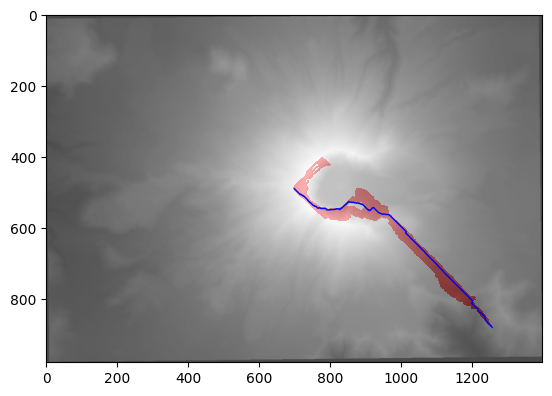

In [109]:
AI = AStarExpImproved()

m = Map(width,length, seed=seed, filename=filename, start=None, goal=None)

t1 = time()
path = AI.create_path(m)
t2 = time()
print('Time (s): ', t2-t1)
m.create_image(path)

Time (s):  144.6103959083557
Path cost: 515.2967010603603
Points explored:  147934


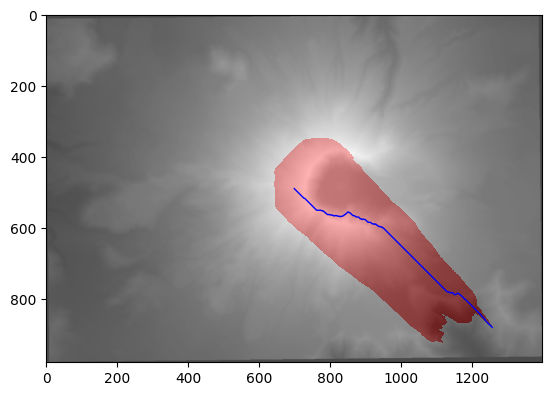

In [110]:
AI = AStarExp()

m = Map(width,length, seed=seed, filename=filename, start=None, goal=None)

t1 = time()
path = AI.create_path(m)
t2 = time()
print('Time (s): ', t2-t1)
m.create_image(path)

## 3.2 Benchmarking your A* Variant on Mount St. Helens

Run the code below to benchmark how AStarExpImproved improves over AStartExp in terms of runtime.

AStarExpImproved should have at least a 10% runtime improvement. Mean cost increase must be less than 10%

**I will run additional hidden tests against your A\* variant to calculate mean_runtime_improvement and mean_cost_increase**

**Please do not change any code here**

In [111]:
AI_base = AStarExp()
AI_improved = AStarExpImproved()

def benchmarkMSH(start, goal):

    # Running AStarExp
    m = Map(None,None, seed=None, filename=filename, start=start, goal=goal)
    t1 = time()
    path = AI_base.create_path(m)
    t2 = time()

    time_base = t2 - t1

    # Running AStarExpImproved
    m = Map(None,None, seed=None, filename=filename, start=start, goal=goal)
    t1 = time()
    path = AI_improved.create_path(m)
    t2 = time()

    time_improved = t2 - t1
    cost_improved = m.calculate_path_cost(path)

    return {
        "time_base" : time_base,
        "time_improved" : time_improved,
        "cost_improved" : cost_improved
        }

# Calculating mean efficiency improvements over 5 different MSH start and goal positions
test_cases = [
    (None, None, 515.2967010603603),
    ((int(width*0.9),int(length*0.4)), (int(width*0.1),int(length*0.2)),805.0520276722111),
    ((int(width*0.25),int(length*0.25)), (int(width*0.75),int(length*0.75)),904.8325859121975),
    ((int(width*0.9),int(length*0.9)), (int(width*0.1),int(length*0.9)),787.2076869022026),
    ((int(width*0.4),int(length*0.4)), (int(width*0.45),int(length*0.45)),157.63237325141134),
]

time_improvement_sum = 0
cost_increase_sum = 0

for t in test_cases:
    results = benchmarkMSH(t[0], t[1])

    cost_diff = results["cost_improved"] - t[2]
    if t[2] != 0:
        cost_increase_sum += cost_diff / t[2]

    time_diff = results["time_base"] - results["time_improved"]
    time_improvement_sum += time_diff / results["time_base"]


time_improvement_mean = (time_improvement_sum / len(test_cases) * 100)
cost_increase_mean = (cost_increase_sum / len(test_cases) * 100)

print(f'mean_runtime_improvement: {round(time_improvement_mean, 2)}%')
print(f'mean_cost_increase: {round(cost_increase_mean, 2)}%')


mean_runtime_improvement: 71.95%
mean_cost_increase: 5.45%


## 3.3 Explaining your A* Variant

Please explain your A* variant, the intuition behind it, and how it improves over vanilla A*.

----
My A* variant is based from a quick research on the link provided by the instructor. In fact, it is a beam search. It limits the fringe's size by removing the nodes with the highest path costs. This helps find the best next move more quickly since there are less nodes to explore on the fringe. Also, the fringe.put(neighbor) line is inside the if statement. In that way we add a node to the fringe only if it is actually a good candidate.
It improves the performance of the original A* algorithm by removing node with less possibility of being on the optimal path. In fact the fringe is firstly sorted by its cost, and then just the first 60 elements of that fringe are actually kept.


----